In [1]:
# ----- LIBS

# geoprocessamento
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box

# normalizar
import numpy as np
from shapely.geometry import mapping
from sklearn.preprocessing import MinMaxScaler

# plots
import matplotlib.pyplot as plt

# gerar e visualizar csv
import csv
import pandas as pd

# Extração de shapes e Plots da Unicamp

- Extração de região geográfica de interesse (bbbike) no formato .shp
- Plot de shapes

In [3]:
# Apontando para o path do dataset do Mapa de Edificações 
# - https://unicamp-arcgis.maps.arcgis.com/apps/View/index.html?appid=1d96ada62af4451bb4972b9779d09e66

import os

current_path = os.getcwd()
# print(current_path)
# print(current_path.find('obstacle_exp'))
# print(current_path[0:current_path.find('obstacle_exp')])

map_dataset_path = current_path[0:current_path.find('obstacle_exp')]
building_shp_path = "datasets/unicamp-arcgis-dataset/edificacoes.shp"

unicamp_building_dataset_path = map_dataset_path + building_shp_path

In [5]:
# ----- READ BUILDING SHAPES DATASET

unicamp_df = gpd.read_file(unicamp_building_dataset_path)
# unicamp_roads_df = gpd.read_file(unicamp_roads_dataset_path)

print('SHAPE:', unicamp_df.shape)
unicamp_df.head(2)

SHAPE: (1170, 8)


,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,geometry
0,444.0,8.0,CASA NO BREAK,"INSTITUTO DE FÍSICA""GLEB WATAGHIN"" (IFGW)",{A3AA0550-2317-433F-888F-BBA6148200AF},49.024480,135.943591,"POLYGON Z ((287762.773 7475309.137 0.000, 2877..."
1,65.0,11.0,DEPÓSITO DE MATERIAIS - DEM,HOSPITAL DE CLÍNICAS (HC),{418DC5B5-3050-40D4-BC58-E4BDFA11D4F3},56.199993,190.900186,"POLYGON Z ((288123.323 7474311.958 0.000, 2881..."


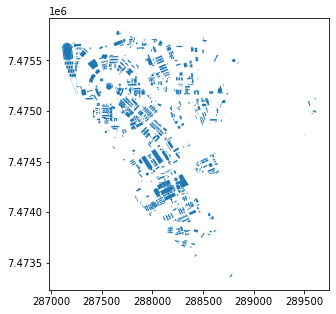

In [6]:
# ----- Plot UNICAMP MAPA Edificações
ax = unicamp_df.plot(figsize=(12, 5))

In [8]:
# Add coluna com centroids

unicamp_df['centroids'] = unicamp_df.centroid
# unicamp_df['centroids']
unicamp_df.head(2)

,Id,PREDIO,NOME_DO_PR,UNIDADE,GlobalID,Shape_Leng,Shape_Area,geometry,centroids
0,444.0,8.0,CASA NO BREAK,"INSTITUTO DE FÍSICA""GLEB WATAGHIN"" (IFGW)",{A3AA0550-2317-433F-888F-BBA6148200AF},49.024480,135.943591,"POLYGON Z ((287762.773 7475309.137 0.000, 2877...",POINT (287754.847 7475304.757)
1,65.0,11.0,DEPÓSITO DE MATERIAIS - DEM,HOSPITAL DE CLÍNICAS (HC),{418DC5B5-3050-40D4-BC58-E4BDFA11D4F3},56.199993,190.900186,"POLYGON Z ((288123.323 7474311.958 0.000, 2881...",POINT (288127.015 7474321.129)


In [ ]:
# predio = unicamp_df[unicamp_df['UNIDADE'].str.contains("INOVA",  na=False)]
# print("SHAPE:", predio.shape)
# predio.head()

# Normalização de Mapa da Unicamp

In [9]:
# Bounds of Unicamp Map
unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy = unicamp_df.geometry.total_bounds

print('bounds:', unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy)
print('x:', unicamp_maxx-unicamp_minx)
print('y:', unicamp_maxy- unicamp_miny)

bounds: 287109.0126 7473356.5109 289617.4537000004 7475795.9585
x: 2508.441100000404
y: 2439.4475999996066


In [ ]:
# get all geometries of unicamp_utm_df
unicamp_geometries = [i for i in unicamp_df.geometry]

# geometry example
unicamp_geometries[2]

In [ ]:
map_minx = 1e+10
map_maxx = -1
map_miny = 1e+10
map_maxy = -1

for geometry in range(len(unicamp_geometries)):
    
    # get all coordinates (x,y) of polygons in unicamp_utm_df
    all_coords_per_geometry = mapping(unicamp_geometries[geometry])["coordinates"] 

    # split all coordinates per geometry and get x coords and y coords
    x_coords = [all_coords_per_geometry[0][i][0] for i in range(len(all_coords_per_geometry[0]))]
    y_coords = [all_coords_per_geometry[0][i][1] for i in range(len(all_coords_per_geometry[0]))]
    
    # convert to 2D array
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    
    # get all geometry coords in x and y
    if geometry == 0:
        all_coords_x = x_coords.copy()
        all_coords_y = y_coords.copy()
    else:
        all_coords_x = np.append (all_coords_x, x_coords.copy(), axis=0)
        all_coords_y = np.append (all_coords_y, y_coords.copy(), axis=0)
        
    # get bounds limits of map and compare with unicamp_utm_df.geometry.total_bounds
    # after for loop, limits must be equal
    if np.min(x_coords) < map_minx:
        map_minx = np.min(x_coords)
    if np.max(x_coords) > map_maxx:
        map_maxx = np.max(x_coords)
    
    if np.min(y_coords) < map_miny:
        map_miny = np.min(y_coords)
    if np.max(y_coords) > map_maxy:
        map_maxy = np.max(y_coords)
    

# after for loop, limits must be equal
print(map_minx, map_miny,map_maxx, map_maxy)
print(unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy)
# yey

# convert to 2D array 
x = np.array(all_coords_x).reshape(-1, 1) # reshape -> 2D array
y = np.array(all_coords_y).reshape(-1, 1)

In [ ]:
# create a normalized map with unicamp bounds

# criando novo mapa, que conterá geometrias normalizadas
mapa_normalizado = gpd.GeoDataFrame(columns=["id","building_number","building_name","unit", "geometry"])
mapa_normalizado['id'] = unicamp_df['Id']
mapa_normalizado['building_number'] = unicamp_df['PREDIO']
mapa_normalizado['building_name'] = unicamp_df['NOME_DO_PR']
mapa_normalizado['unit'] = unicamp_df['UNIDADE']

# processo de normalização
for geometry in range(len(unicamp_geometries)):

    # get all coordinates (x,y) of polygons in unicamp_utm_df
    all_coords_per_geometry = mapping(unicamp_geometries[geometry])["coordinates"] 
    
    # split all coordinates per geometry and get x coords and y coords
    x_coords = [all_coords_per_geometry[0][i][0] for i in range(len(all_coords_per_geometry[0]))]
    y_coords = [all_coords_per_geometry[0][i][1] for i in range(len(all_coords_per_geometry[0]))]
    
    # convert to 2D array
    x_coords = np.array(x_coords).reshape(-1, 1) 
    y_coords = np.array(y_coords).reshape(-1, 1)
    
    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))
    
    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)
    
    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)
    
    # convert np array x and y normalized back to polygon
    building_geometry = np.append (transform_x, transform_y, axis=1)
    new_polygon = Polygon(building_geometry)
    
    mapa_normalizado.loc[geometry, 'geometry'] = new_polygon
    

print('Shape do Mapa normalizado:', mapa_normalizado.shape)
mapa_normalizado.head(3)

In [ ]:
# ANTES E DEPOIS DA NORMALIZAÇÃO

fig, axes = plt.subplots(1,2, figsize = (14, 7)) # 1 linha, 2 colunas

# Mapa da unicamp no crs SIRGAS 2000/ UTM 23S
axes[0].set_title('SIRGAS 2000 / UTM 23S', fontsize=15, y=1.02)
unicamp_df.plot(ax=axes[0])

# Mapa da Unicamp
# onde:
# - unicamp bounds = 285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968
# - maxx - minx    = 4387.848261102627
# - maxy - miny    = 2661.465870924294
title = 'Mapa Normalizado (~' + str(round(unicamp_maxx-unicamp_minx,2)) + ' x ' + str(round(unicamp_maxy-unicamp_miny,2)) + "metros)" 
axes[1].set_title(title,fontsize=15, y=1.02)
mapa_normalizado.plot(ax=axes[1])

plt.show()

In [ ]:
mapa_normalizado.head(3)

In [ ]:
# Some useful functions

from shapely.geometry import Point
from shapely.geometry import box


ref_osm_id = int(10000000)
def add_dataset_rows(geodataset, new_polygon, name, type_building ):
    global ref_osm_id
    last_index = geodataset.shape[0]
    geodataset.loc[last_index, 'geometry'] = new_polygon
    geodataset.loc[last_index, 'osm_id'] = ref_osm_id
    geodataset.loc[last_index, 'name'] = name
    geodataset.loc[last_index, 'type'] = type_building
    ref_osm_id = int(ref_osm_id + 1)
    print("Novo Shape:", geodataset.shape)
    
    return geodataset.iloc[geodataset.shape[0]-1:geodataset.shape[0]]


def add_node_dataset_rows(geodataset, name, type_building, point):
    global ref_osm_id
    last_index = geodataset.shape[0]
    geodataset.loc[last_index, 'osm_id'] = ref_osm_id
    geodataset.loc[last_index, 'name'] = name
    geodataset.loc[last_index, 'type'] = type_building
    geodataset.loc[last_index, 'x'] = point.x
    geodataset.loc[last_index, 'y'] = point.y
    geodataset.loc[last_index, 'z'] = 1.5
    
    ref_osm_id = int(ref_osm_id + 1)
    print("Novo Shape:", geodataset.shape)
    
    return geodataset.iloc[geodataset.shape[0]-1:geodataset.shape[0]]

def get_polygon_coords (polygon):
    g = [i for i in polygon.geometry]
    x,y = g[0].exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    
    return coords


def create_circle_building(x, y, buffer):
    circle = Point(x, y).buffer(buffer) 

    print("Area:", circle.area)
    print("Length:", circle.length)
    
    return circle

def create_box_building(building_name, bounds, offset_xmin, offset_ymin, offset_xmax, offset_ymax):
    new_building = box(
        bounds[0] - offset_xmin,
        bounds[1] - offset_ymin,
        bounds[2] -offset_xmax,
        bounds[3] -offset_ymax
    )

    print("Bounds do prédio " + str(building_name) + ":", bounds)
    print("\nÁrea:", new_building.area)
    print("Length:", new_building.length)
    
    return new_building


def compare_buildings(ref_building, new_building):
    geodataset_ref = gpd.GeoSeries(ref_building)
    ax = geodataset_ref.plot(color='Gray')

    geodataset_new = gpd.GeoSeries(new_building)
    geodataset_new.plot(ax=ax) 

    
def calculate_distance(osm_id, new_polygon):
    # ----- Criação de Geodataframe para o calculo de distancia entre centroids do Museu e predio de referência (Inova)
    points_df = gpd.GeoDataFrame(columns=["geometry"])
    points_df.loc[:, 'geometry'] = mapa_normalizado.query('osm_id ==' + str(osm_id))['geometry']
    points_df.loc[0, 'geometry'] = new_polygon

    points_df['centroid'] = points_df["geometry"].centroid

    # Cálculo de Distância entre Circle centroids e cada linha do dataset
    print("Distancia entre centroids:\n", points_df.distance(new_polygon.centroid))

    return points_df

## Buscar e Mapear predios

In [ ]:
# ----- RESULTADOS DO MAPEAMENTO (prédios com coletores) # id, num_predio

# ENCONTRADOS POR CONSULTA DE NOME:
# 1. Agência de Inovação Inova Unicamp (INOVA)  # 1321.0 , 1.0 
# 2. Biblioteca Central (BC)   # 535.0, 5.0
# 3. Centro de Biologia Molecular e Engenharia Genética (CBMEG)   # 802.0, 9.0
# 4. Centro de Componentes Semicondutores (CCS)   # 175.0, 1.0 
# 5. Centro de Computação (CCUEC)   # 845.0, 8.0
# 6. Centro de Diagnóstico de Doenças do Aparelho Digestivo (GASTROCENTRO) # 1037.0, 6.0
# 7. Centro de Estudos de Petróleo (CEPETRO) # 1115.0, 6.0
# 8. Centro de Hematologia e Hemoterapia (HEMOCENTRO) # 1038.0, 7.0
# 9. Centro para Manutenção de Equipamentos (CEMEQ) # 960.0, 15.0 
# 10. Ciclo Básico I   #  671.0, 11.0 
# 11. Ciclo Básico II  #  663.0, 3.0
# 12. Coordenadoria de Desenvolvimento Cultural (CDC) # 533.0, 3.0
# 13. Diretoria Geral da Administração (DGA) # 29.0, 1.0
# 14. Diretoria Geral de Recursos Humanos (DGRH) # 9.0, 5.0
# 15. Divisão de Educação Infantil e Complementar (DEdIC) # 1211.0, 1.0
# 16. Engenharia Básica (EB)  # 175.0, 1.0 ~
# 17. Escola Estadual de Ensino Fundamental Físico Sérgio Pereira Porto (SERGIO PORTO) # 1220.0, 10.0
# 18. Faculdade de Ciências Médicas (FCM) # 1238.0, 1.0 
# 19. Faculdade de Educação Física (FEF)  # 727.0, 30.0
# 20. Faculdade de Enfermagem (FEnf)      # 1240.0, 3.0
# 21. Faculdade de Engenharia Agrícola (FEAGRI)   # 881.0, 1.0
# 22. Faculdade de Engenharia Civil, Arquitetura e Urbanismo (FEC)  # 1282.0, 4.0
# 23. Faculdade de Engenharia de Alimentos (FEA)   # 300.0, 2.0
# 24. Faculdade de Engenharia Elétrica e de Computação (FEEC) # 278.0, 2.0
# 25. Faculdade de Engenharia Mecânica (FEM)   # 1151.0, 6.0
# 26. Faculdade de Engenharia Química (FEQ)    # 971.0, 28.0
# 27. Fundação de Desenvolvimento da Unicamp (FUNCAMP) # --------
# 28. Gabinete do Reitor (GR)      # 1.0, 1.0
# 29. Grupo Gestor de Obras (GGO)  # 195.0, 8.0
# 30. Hospital de Clínicas (HC)    # 59.0, 6.0
# 31. Instituto de Artes (IA)      # 513.0, 2.0
# 32. Instituto de Biologia (IB)   # 604.0, 5.0
# 33. Instituto de Computação (IC) # 776.0, 2.0
# 34. Instituto de Estudos da Linguagem (IEL) # 
# 35. Instituto de Filosofia e Ciências Humanas (IFCH) # 
# 36. Instituto de Física Gleb Wataghin (IFGW) # 
# 37. Instituto de Geociências (IG) da Rua Oswaldo Cruz (inferior) 
# 38. Instituto de Geociências (IG) da Avenida Érico Veríssimo (superior)
# 39. Instituto de Matemática, Estatística e Computação Científica (IMECC) # 
# 40. Instituto de Química (IQ) # 
# 41. Prefeitura Universitária # 
# 45. Restaurante Administrativo (RA) # 
# 46. Restaurante Saturnino (RS) #
# 47. Restaurante Universitário (RU) #

# NÃO ESTÃO NO MAPA:
# 27. Fundação de Desenvolvimento da Unicamp (FUNCAMP) # --------

# Casos especiais:
# 42. Ponto de ônibus – Rua Roxo Moreira (PO-RM)
# 43. Ponto de ônibus – Avenida Adolpho Lutz (PO-AL)
# 44. Ponto de ônibus – Rua Vital Brasil (PO-VB)

In [ ]:
# ----- MÉTODOS DE BUSCA PARA MAPEAMENTO

# Busca por linha em todo dataset
predio = mapa_normalizado.iloc[536:537] #ex Comvest 536-537
# print(mapa_normalizado.shape)
predio.head(predio.shape[0])

# Busca por Nome
# predio = mapa_normalizado[mapa_normalizado['building_name'].str.contains("COMVEST",  na=False)]
# # predio = mapa_normalizado[mapa_normalizado['unit'].str.contains("Comvest",  na=False)]
# print("SHAPE:", predio.shape)
# predio.head(22)

# Busca de todos os predios com Nome None
# predio_sem_indentificacao = mapa_normalizado[mapa_normalizado['name'].isna()]
# predio = predio_sem_indentificacao
# predio.head()

# Busca por linhas de todos os predios com Nome None
# predio_sem_indentificacao = mapa_normalizado[mapa_normalizado['name'].isna()]
# predio = predio_sem_indentificacao.iloc[47:48] # ex HC
# predio.head()

In [ ]:
predio.plot(color="red")

In [ ]:
### ----- PLOT DE PREDIO DE ACORDO COM A BUSCA REALIZADA

ax = mapa_normalizado.plot(figsize=(12, 5))

# predios None
predio['geometry'].plot(ax=ax, color='Red')

# Para ampliar area mudar param. de set_xlim e set_ylim
# minx, miny, maxx, maxy = mapa_normalizado.total_bounds
# ax.set_xlim(minx -100, maxx)
# ax.set_ylim(miny -100, maxy)

## Cria e ADD Pontos não encontrados

### IG (parte inferior) e EB

In [ ]:
# Tratamento para que prédio do IG e EB não tenham o mesmo centroid do prédio com o ID 554951142

ref_id = 554951142
point_IG = mapa_normalizado.query('osm_id ==' + str(ref_id))
print(point_IG['geometry'].centroid)

# Get Polygon value
# get_polygon_coords(point_IG)

In [ ]:
# Reposicionando posicionamento do IG e EB (ao inves de centroid do prédio)
pt_IG = Point(2110, 1110)
pt_EB = Point(2060, 1210)

# Plot de paradas de ÔNIBUS
pt_IG_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:31983')
pt_IG_df.loc[0, 'geometry'] = pt_IG
pt_IG_df.loc[1, 'geometry'] = Point (2089.558, 1166.068) # point_IG['geometry'].centroid
pt_IG_df.loc[2, 'geometry'] = pt_EB

ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
pt_IG_df.plot(ax=ax, color="black")

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(1500, 3000)
ax.set_ylim(1000, 1500)

### Paradas de Ônibus

In [ ]:
# Coordenadas obtidas pelo notebook "Mapa dinâmico"
# Google Maps ajuda nessa parte tb

parada_RM = Point(-47.0677, -22.8242) 
parada_AL = Point(-47.0629, -22.8319) 
parada_VB = Point(-47.0628, -22.8275)

# Convertendo Coordenadas em Degree para metros (31983)
pontos_onibus_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:4326')
pontos_onibus_df.loc[0, 'geometry'] = parada_RM
pontos_onibus_df.loc[1, 'geometry'] = parada_AL
pontos_onibus_df.loc[2, 'geometry'] = parada_VB
pontos_onibus_df = pontos_onibus_df.to_crs('EPSG:31983')
# pontos_onibus_df.crs
pontos_onibus_df

In [ ]:
# PONTOS no CRS EPSG:31983
parada_RM = Point(pontos_onibus_df['geometry'][0])
parada_AL = Point(pontos_onibus_df['geometry'][1])
parada_VB = Point(pontos_onibus_df['geometry'][2])

print(parada_RM)
print(parada_AL)
print(parada_VB)

In [ ]:
# NORMALIZAÇÃO DE PONTOS 

points = [parada_RM, parada_AL, parada_VB]
norm_points = []

# convert to 2D array 
x = np.array(all_coords_x).reshape(-1, 1) # reshape -> 2D array
y = np.array(all_coords_y).reshape(-1, 1)

for coords in points:
    # convert to 2D array
    x_coords = np.array([coords.x]).reshape(-1, 1)
    y_coords = np.array([coords.y]).reshape(-1, 1)

    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))

    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)

    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)

    print(transform_x, transform_y)
    norm_points.append(Point(transform_x, transform_y))

print(norm_points[0])

In [ ]:
# p/ Plotar paradas de ÔNIBUS
pontos_onibus_norm_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:31983')
pontos_onibus_norm_df.loc[0, 'geometry'] = norm_points[0]
pontos_onibus_norm_df.loc[1, 'geometry'] = norm_points[1]
pontos_onibus_norm_df.loc[2, 'geometry'] = norm_points[2]

pontos_onibus_norm_df

In [ ]:
# Plot de paradas de ÔNIBUS
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
pontos_onibus_norm_df.plot(ax=ax, color="black")

In [ ]:
a =  mapa_normalizado.iloc[mapa_normalizado.shape[0]-10: mapa_normalizado.shape[0]]
a

# Criação de dataset dos Prédios da Unicamp

- Create a xml file with Unicamp Building shapes & height
- The outuput xml file will serve as input of NS3

In [ ]:
# estudando e tratando a string Polygon
polygon_str = str(mapa_normalizado['geometry'][0])
polygon_coords = polygon_str[polygon_str.find("(") + 2:]
polygon_coords = polygon_coords[ : polygon_coords.find(")")]
polygon_coords

In [ ]:
# Criando xml dataset
from xml.dom import minidom
import os 
  
root = minidom.Document()
  
xml = root.createElement('additional') 
xml.setAttribute('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
xml.setAttribute('xsi:noNamespaceSchemaLocation','http://sumo.dlr.de/xsd/additional_file.xsd')
root.appendChild(xml)

for i in range(len(mapa_normalizado['geometry'])):   
    
    polygon_str = str(mapa_normalizado['geometry'][i])
    polygon_coords = polygon_str[polygon_str.find("(") + 2:]
    polygon_coords = polygon_coords[ : polygon_coords.find(")")]
    
    productChild = root.createElement('poly')
    productChild.setAttribute('id', str(mapa_normalizado['id'][i]))
    productChild.setAttribute('type', 'university')
    productChild.setAttribute('color', '255.0,230.0,230.0')
    productChild.setAttribute('layer', '-1.0')
    productChild.setAttribute('fill', '1')
    productChild.setAttribute('height', '6.1')
    productChild.setAttribute('shape', polygon_coords)
  
    xml.appendChild(productChild)
  
xml_str = root.toprettyxml(indent ="\t") 
  
save_path_file = "predios_unicamp_dataset.xml"
  
with open(save_path_file, "w") as f:
    f.write(xml_str) 


In [ ]:
print("SHAPE:", mapa_normalizado.shape)

# Criação de dataset do posicionamento dos Coletores

- Buscar e Mapear predios que contem coletores
    - https://www.prefeitura.unicamp.br/2016/02/26/programa-de-coleta-de-pilhas-e-baterias-instalacao-de-coletores/
    - https://unicamp-arcgis.maps.arcgis.com/apps/View/index.html?appid=1d96ada62af4451bb4972b9779d09e66

- Rotular prédios sem nome
    - Anotar centroids de prédios mapeados
- Criar dataset de posicionamento de nós

## Rotular prédios sem nome

In [ ]:
# Dataset de Prédios com coletores
building_label = {
    "163762428":"INOVA",
    "95463723": "BC",
    "10000003": "CBMEG",
    "554951142": "CCS",
    "10000002": "CCUEC",
    "556327645": "GASTROCENTRO",
    "562047735": "CEPETRO",
    "556327636": "HEMOCENTRO",
    "556327686": "CEMEQ",
    "10000004": "CBI",
    "95011161": "CBII",
    "95463720": "CDC",
    "554951141": "DGA",
    "362643631": "DGRH",
    "537155702": "DEdIC",
    "10000005": "Sergio porto",
    "537142892": "FCM",
    "96446654": "FEF",
    "537142893": "FEnf",
    "97592693": "FEAGRI",
    "556327678": "FEC",
    "554951120": "FEA",
    "269851018": "FEEC",
    "554951124": "FEM",
    "554968138": "FEQ",
    "556327623": "FUNCAMP",
    "562047779": "GR",
    "10000006": "GGO", 
    "538334949": "HC",
    "537166697": "IA",
    "95540601": "IB",
    "95011169": "IC",
    "556327698": "IEL",
    "95463722": "IFCH", 
    "556327703": "IFGW",
    "10000001": "IG-CIMA", 
    "95463724": "IMECC",
    "96493946": "IQ",
    "562047775": "PREFEITURA",
    "269851019": "RA",
    "270488633": "RS",
    "95463718": "RU",        
} 

nodes_df = gpd.GeoDataFrame(columns=['osm_id', 'name', 'type', 'geometry', 'centroid'])

# Labeling buildings
aux = 0
for key, value in building_label.items():
    building = mapa_normalizado.query('osm_id ==' + str(key))
    building_n = building.copy()
    building_n.loc[building.index, 'name'] = value
    nodes_df.loc[aux, ['osm_id']] = building_n['osm_id'].values   
    nodes_df.loc[aux, ['name']] = building_n['name'].values    
    nodes_df.loc[aux, ['type']] = building_n['type'].values
    nodes_df.loc[aux, ['geometry']] = building_n['geometry'].values
#     nodes_df.loc[aux, ['centroids']] = building_n['centroids'].values
    
    aux = aux + 1
    
nodes_df.head()
# nodes_df.shape


In [ ]:
nodes_df['centroid'] = nodes_df.centroid
nodes_df.head()

In [ ]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

# predios com coletores
nodes_df['geometry'].plot(ax=ax, color="red")

## Criar dataset de posicionamento de nós

In [ ]:
# GENERATE BUILDINGS CSV FILE

#---- create a csv file
def create_csv(title, colunms_names):
    with open(title,"w+") as file:
        writer = csv.writer(file, delimiter=",")
        writer.writerow(colunms_names)


#---- add row on csv file
def add_csv_rows(ns3_settings, colunms_names, title):
    for colunm in ns3_settings:
        if len(colunm) == len(colunms_names):
            with open(title,"a") as file:
                writer = csv.writer(file, delimiter=",")
                writer.writerow([x for x in colunm])


In [ ]:
colunms_names  = ['osm_id', 'name', 'type', 'x', 'y', 'z']

nodes_pos = []
for i in range(len(nodes_df.geometry)):
    # tratando a string Point
    point_str = str(nodes_df['centroid'][i])
    point_coords = point_str[point_str.find("(") + 1:]
    point_coords = point_coords[ : point_coords.find(")")]
    x = point_coords.split()[0]
    y = point_coords.split()[1]
    z = 1.5

    items_per_row = [nodes_df.loc[i]['osm_id'],
              nodes_df.loc[i]['name'],
              nodes_df.loc[i]['type'],
              x, y, z]
    
    nodes_pos.append(items_per_row)

output_filename = 'coletores_pos_dataset.csv'
create_csv(output_filename, colunms_names)
add_csv_rows(nodes_pos, colunms_names, output_filename)

In [ ]:
node_pos_df = pd.read_csv("coletores_pos_dataset.csv") 

print("DATASET SHAPE:", node_pos_df.shape)
node_pos_df.head()

## ADD pontos não encontrados

In [ ]:
# ADD pontos
add_node_dataset_rows(node_pos_df, "IG-baixo", "university", pt_IG)
add_node_dataset_rows(node_pos_df, "EB", "university", pt_EB)
add_node_dataset_rows(node_pos_df, "PO-RM", "stop_bus", norm_points[0]) # parada_RM
add_node_dataset_rows(node_pos_df, "PO-AL", "stop_bus", norm_points[1]) # parada_AL
add_node_dataset_rows(node_pos_df, "PO-VB", "stop_bus", norm_points[2]) # parada_VB

In [ ]:
view = node_pos_df.iloc[node_pos_df.shape[0]-10:node_pos_df.shape[0]]
view

In [ ]:
ax = mapa_normalizado['geometry'].plot(figsize=(15, 7))

# centroids
nodes_df["centroid"].plot(ax=ax, color="black")


# Salvando Mapa de prédios da Unicamp Normalizado (shapefile)

In [ ]:
# verificando se não foi atribuindo um CRS anteriormente
mapa_normalizado.crs is None

In [ ]:
# atribuindo um CRS
mapa_normalizado = mapa_normalizado.set_crs('epsg:31983')
mapa_normalizado.crs  

In [ ]:
# SALVANDO MAPA NORMALIZADO DE PRÉDIOS no formato Shapefile
mapa_normalizado.to_file('mapa_predios_unicamp_normalizado.shp')

# Testando abrir arquivo salvo
unicamp_gdf = gpd.read_file('mapa_predios_unicamp_normalizado.shp')

In [ ]:
ax = unicamp_gdf['geometry'].plot(figsize=(15, 7), color='purple')

# Dataset de Nós - Experimentos Reais

In [ ]:
#---- EXTRACT LAT, LNG and RSSI VALUES FROM txt dataset

# The dataset used here is available on: https://github.com/helderbetiol/LoRaWAN-IC2019
def get_txt_values(filename):
    
    # list of all rows of buildings_settings
    file_rows = []

    # open file in a read mode
    file = open(filename, 'r')

    for line in file.readlines():
        
        # create a str without \n and ","
        line_str = line.strip().split("\t")  
        file_rows.append(line_str)
    
    # remove colunm names
    file_rows.pop(0)
    
    return file_rows

In [ ]:
# Apontando para o path do dataset da Unicamp
current_path = os.getcwd()
map_dataset_path = current_path[:current_path.find('obstacle_exp')]

# print(current_path)
# print(map_dataset_path)
dataset_path = "datasets/exp-reais-dataset/table-rssi-2805"
txt_rows = get_txt_values(map_dataset_path + dataset_path)
# txt_rows

In [ ]:
# Coordenadas obtidas pelo notebook "Mapa dinâmico"
points_list = []

for row in txt_rows:
    lat = float(row[1])
    lng = float(row[0])
    points_list.append(Point(lat, lng))

In [ ]:
# Convertendo Coordenadas em Degree para metros (31983)
pontos_rssi_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:4326')
for index in range(len(points_list)):
    pontos_rssi_df.loc[index, 'geometry'] = points_list[index]
    

# PONTOS no CRS EPSG:31983
pontos_rssi_df = pontos_rssi_df.to_crs('EPSG:31983')
    
    
print("CRS:\t", pontos_rssi_df.crs)
print("SHAPE:", pontos_rssi_df.shape)
pontos_rssi_df.head()

In [ ]:
# NORMALIZAÇÃO DE PONTOS 

points_list_meters = []
for i in range(len(pontos_rssi_df['geometry'])):
    points_list_meters.append(pontos_rssi_df['geometry'][i])
    
norm_points = []

# convert to 2D array 
x = np.array(all_coords_x).reshape(-1, 1) # reshape -> 2D array
y = np.array(all_coords_y).reshape(-1, 1)

for coords in points_list_meters:
    # convert to 2D array
    x_coords = np.array([coords.x]).reshape(-1, 1)
    y_coords = np.array([coords.y]).reshape(-1, 1)

    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))

    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)

    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)

#     print(transform_x, transform_y)
    norm_points.append(Point(transform_x, transform_y))

print(norm_points[0])

In [ ]:
# p/ Plotar pontos RSSI
pontos_rssi_norm_df = gpd.GeoDataFrame(columns=["geometry", "rssi"],  crs='EPSG:31983')

for index in range(len(norm_points)):
    pontos_rssi_norm_df.loc[index, 'geometry'] = norm_points[index]
    pontos_rssi_norm_df.loc[index, 'rssi'] = txt_rows[index][2]

pontos_rssi_norm_df.head()

In [ ]:
# visualização de pontos normalizados

ax = mapa_normalizado['geometry'].plot(figsize=(15, 7))

# pontos_rssi_norm_df.plot(ax =ax, color= 'red', alpha=0.5, linewidth=0.5, edgecolor='k')
pontos_rssi_norm_df.plot(ax =ax, color= 'red', alpha=0.5, linewidth=1, markersize =7)

In [ ]:
pontos_rssi_norm_df.head()

In [ ]:
# Criar csv

colunms_names  = ['rssi', 'x', 'y', 'z']

nodes_pos = []
for i in range(len(pontos_rssi_norm_df.geometry)):
    # tratando a string Point
    point_str = str(pontos_rssi_norm_df['geometry'][i])
    point_coords = point_str[point_str.find("(") + 1:]
    point_coords = point_coords[ : point_coords.find(")")]
    x = point_coords.split()[0]
    y = point_coords.split()[1]
    z = 1.5

    items_per_row = [
        pontos_rssi_norm_df.loc[i]['rssi'],
        x,
        y,
        z
    ]
    
    nodes_pos.append(items_per_row)

output_filename = 'rssi_dataset.csv'
create_csv(output_filename, colunms_names)
add_csv_rows(nodes_pos, colunms_names, output_filename)

In [ ]:
# visualizando dataset criado
rssi_node_pos_df = pd.read_csv('rssi_dataset.csv') 

print("DATASET SHAPE:", rssi_node_pos_df.shape)
rssi_node_pos_df.head()